# UMAP
## Sparse Data

In [1]:
import numpy as np
import scipy.sparse
import sympy
import sklearn.datasets
import sklearn.feature_extraction.text
import umap
import umap.plot
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
primes = list(sympy.primerange(2, 1100))
prime_to_column = {p:i for i, p in enumerate(primes)}

In [3]:
%%time
lil_matrix_rows = []
lil_matrix_data = []
for n in range(1000):
    prime_factors = sympy.primefactors(n)
    lil_matrix_rows.append([prime_to_column[p] for p in prime_factors])
    lil_matrix_data.append([1] * len(prime_factors))

CPU times: user 9.6 ms, sys: 0 ns, total: 9.6 ms
Wall time: 9.21 ms


In [4]:
factor_matrix = scipy.sparse.lil_matrix((len(lil_matrix_rows), len(primes)), dtype=np.float32)
factor_matrix.rows = np.array(lil_matrix_rows, dtype='object')
factor_matrix.data = np.array(lil_matrix_data, dtype='object')
factor_matrix

<1000x184 sparse matrix of type '<class 'numpy.float32'>'
	with 2124 stored elements in List of Lists format>

In [5]:
%%time
mapper = umap.UMAP(metric='cosine', random_state=42, low_memory=True).fit(factor_matrix)

/home/c44406/loan_potf_opt/lib/python3.7/site-packages/umap/umap_.py:126: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 609580 edges.
It has only fully disconnected 75 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  f"A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.\n"


CPU times: user 11.1 s, sys: 1.26 s, total: 12.4 s
Wall time: 10.8 s


<AxesSubplot:>

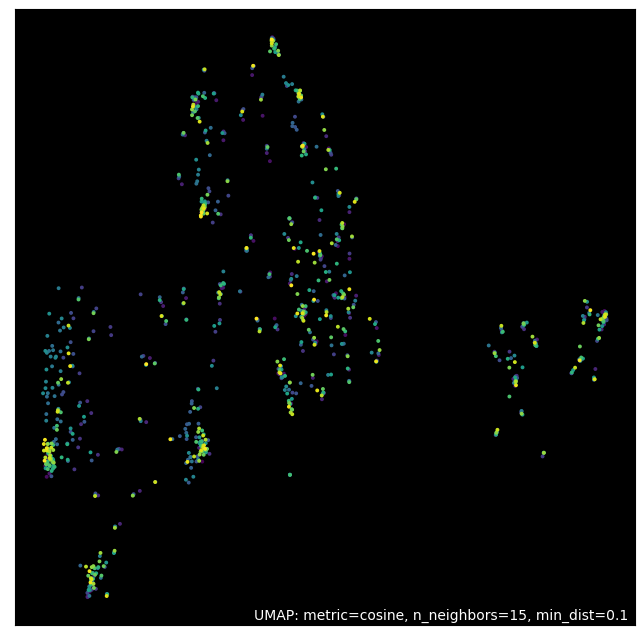

In [6]:
umap.plot.points(mapper, values=np.arange(1000), theme='viridis')

## Parametric Embedding

In [14]:
from tensorflow.keras.datasets import mnist

In [15]:
# load dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
X = train_images.reshape((60000, 28, 28, 1))
X.shape

(60000, 28, 28, 1)

### Building graph

In [16]:
from pynndescent import NNDescent
import numpy as np

In [17]:
# number of trees in random projection forest
n_trees = 5 + int(round((X.shape[0]) ** 0.5 / 20.0))
# max number of nearest neighbor iters to perform
n_iters = max(5, int(round(np.log2(X.shape[0]))))
# distance metric
metric="euclidean"
# number of neighbors for computing k-neighbor graph
n_neighbors = 10

# get nearest neighbors
nnd = NNDescent(
    X.reshape((len(X), np.product(np.shape(X)[1:]))),
    n_neighbors=n_neighbors,
    metric=metric,
    n_trees=n_trees,
    n_iters=n_iters,
    max_candidates=60,
    verbose=True
)
# get indices and distances
knn_indices, knn_dists = nnd.neighbor_graph

Wed Sep 22 16:14:02 2021 Building RP forest with 17 trees
Wed Sep 22 16:14:07 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations


In [18]:
# nearest neighbors and distances for each point in the dataset
np.shape(knn_indices), np.shape(knn_dists)

((60000, 10), (60000, 10))

### Build fuzzy simplicial complex

In [19]:
from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set

In [20]:
# get indices and distances
knn_indices, knn_dists = nnd.neighbor_graph
random_state = check_random_state(None)

In [21]:
# build fuzzy_simplicial_set
umap_graph, sigmas, rhos = fuzzy_simplicial_set(
    X = X,
    n_neighbors = n_neighbors,
    metric = metric,
    random_state = random_state,
    knn_indices= knn_indices,
    knn_dists = knn_dists,
)

In [22]:
umap_graph

<60000x60000 sparse matrix of type '<class 'numpy.float32'>'
	with 803514 stored elements in Compressed Sparse Row format>

## Part 2: Embedding the graph

### Create neural network model

In [23]:
import tensorflow as tf

In [24]:
n_components = 2 # number of latent dimensions
dims = X.shape[1:]
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3211776   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 3,549,954
Trainable params: 3,549,954
Non-trainable params: 0
______________________________________________

### create batch iterator

In [25]:
from umap.parametric_umap import construct_edge_dataset

In [26]:
# n_epochs isused to compute epochs_per_sample, which, in non-parametric UMAP, 
# is the total number of epochs to optimize embeddings over. The computed value 
# epochs_per_sample, is the number of epochs  each edge is optimized over 
# (higher probability = more epochs).
n_epochs = 200 

batch_size = 1000 # iterate over batches of 1000 edges

In [27]:
# get tensorflow dataset of edges 
(
    edge_dataset,
    batch_size,
    n_edges,
    head,
    tail,
    edge_weight,
) = construct_edge_dataset(
    X,
    umap_graph,
    n_epochs,
    batch_size,
    parametric_embedding = True,
    parametric_reconstruction = False,
)

In [28]:
(sample_edge_to_x, sample_edge_from_x), _ =  next(iter(edge_dataset))
sample_edge_to_x.shape

TensorShape([1000, 28, 28, 1])

In [29]:
import matplotlib.pyplot as plt

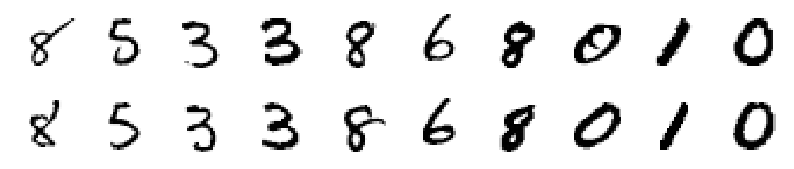

In [30]:
# plot sampled neighbors from graph
fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(10,2))
for i in range(10):
    axs[0,i].matshow(np.squeeze(sample_edge_to_x[i]), cmap=plt.cm.Greys)
    axs[1,i].matshow((np.squeeze(sample_edge_from_x[i])), cmap=plt.cm.Greys)
    axs[0,i].axis('off')
    axs[1,i].axis('off')

### Compute loss over a batch

In [31]:
from umap.parametric_umap import umap_loss

In [32]:
from umap.umap_ import find_ab_params

In [33]:
min_dist = 0.1 # controls how tightly UMAP is allowed to pack points together (0 is more)

In [34]:
_a, _b = find_ab_params(1.0, min_dist)

### Grab the embeddings

In [35]:
# grab z for the edge
embedding_to = encoder.predict(sample_edge_to_x)
embedding_from = encoder.predict(sample_edge_from_x)

In [36]:
negative_sample_rate = 5 # how many negative samples to train on per edge. 

In [37]:
# get negative samples by randomly shuffling the batch
embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
embedding_neg_from = tf.gather(
    repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
)

In [38]:
# Euclidean distances between samples (and negative samples)
distance_embedding = tf.concat(
    [
        tf.norm(embedding_to - embedding_from, axis=1),
        tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
    ],
    axis=0,
)

In [39]:
def convert_distance_to_probability(distances, a=1.0, b=1.0):
    return 1.0 / (1.0 + a * distances ** (2 * b))

# convert probabilities to distances
probabilities_distance = convert_distance_to_probability(
    distance_embedding, _a, _b
)

In [40]:
# set true probabilities based on negative sampling
probabilities_graph = tf.concat(
    [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)], axis=0,
)

In [41]:
def compute_cross_entropy(
    probabilities_graph, probabilities_distance, EPS=1e-4, repulsion_strength=1.0
):
    # cross entropy
    attraction_term = -probabilities_graph * tf.math.log(
        tf.clip_by_value(probabilities_distance, EPS, 1.0)
    )
    repellant_term = (
        -(1.0 - probabilities_graph)
        * tf.math.log(tf.clip_by_value(1.0 - probabilities_distance, EPS, 1.0))
        * repulsion_strength
    )

    # balance the expected losses between atrraction and repel
    CE = attraction_term + repellant_term
    return attraction_term, repellant_term, CE

In [42]:
# compute cross entropy
(attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
    probabilities_graph,
    probabilities_distance,
)

In [43]:
from umap.parametric_umap import umap_loss 

umap_loss_fn = umap_loss(
    batch_size,
    negative_sample_rate,
    _a,
    _b,
    edge_weight,
    parametric_embedding = True
)

### Define and compile the Keras model

In [44]:
# define the inputs
to_x = tf.keras.layers.Input(shape=dims, name="to_x")
from_x = tf.keras.layers.Input(shape=dims, name="from_x")
inputs = [to_x, from_x]

# parametric embedding
embedding_to = encoder(to_x)
embedding_from = encoder(from_x)

# concatenate to/from projections for loss computation
embedding_to_from = tf.concat([embedding_to, embedding_from], axis=1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name="umap")(
    embedding_to_from
)
outputs = {'umap': embedding_to_from}

# create model
parametric_model = tf.keras.Model(inputs=inputs, outputs=outputs,)

In [45]:
optimizer = tf.keras.optimizers.Adam(1e-3)

In [46]:
parametric_model.compile(
    optimizer=optimizer, loss=umap_loss_fn
)

### Fit model

In [47]:
# Steps per epoch determines how many training steps we take, before keras 
#. starts a new epoch. To get more frequent reporting, you can set the number
#. of epochs higher and the number of steps per epoch lower. 
steps_per_epoch = int(
    n_edges / batch_size / 5
)

In [ ]:
# create embedding
history = parametric_model.fit(
    edge_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    max_queue_size=100,
)

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
# Project data
z = encoder.predict(X)

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=train_labels,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP embeddings", fontsize=20)